In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import cv2
from tqdm import tqdm
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2024-02-20 18:02:14.998498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 18:02:15.442798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/foc-dba-38-0026-c/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-02-20 18:02:15.442836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/foc-dba-38-0026-c/.local/lib/python3.8/site-pack

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir = "/home/foc-dba-38-0026-c/skin_detction/Dataset/train"

In [3]:
# List subdirectories and sort them in the desired order
subdirectories = [subdir for subdir in os.listdir(dir) if os.path.isdir(os.path.join(dir, subdir))]
desired_order = ['Combination', 'Dry', 'Normal', 'Oily']
subdirectories = sorted(subdirectories, key=lambda x: desired_order.index(x))

# Count the number of image files in each subdirectory
for subdir in subdirectories:
    sub_dir_path = os.path.join(dir, subdir)
    image_files = [file for file in os.listdir(sub_dir_path) if file.lower().endswith(('.jpg'))]
    num_images = len(image_files)

    print(f"Subdirectory: {subdir}, Number of images: {num_images}")

Subdirectory: Combination, Number of images: 474
Subdirectory: Dry, Number of images: 800
Subdirectory: Normal, Number of images: 1299
Subdirectory: Oily, Number of images: 884


In [6]:
# Create a dictionary to store unique pixel heights and widths for each class
class_pixel_info = {class_name: {'heights': set(), 'widths': set()} for class_name in desired_order}

# Iterate through the classes in the desired order
for class_name in desired_order:
    class_dir = os.path.join(dir, class_name)
    image_files = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg'))]

    # Calculate unique pixel heights and widths for each image in the class
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            class_pixel_info[class_name]['heights'].add(height)
            class_pixel_info[class_name]['widths'].add(width)

# Print unique pixel heights and widths for each class
for class_name, pixel_info in class_pixel_info.items():
    print(f"Class: {class_name}")
    print("Unique Pixel Heights:", pixel_info['heights'])
    print("Unique Pixel Widths:", pixel_info['widths'])
    print()


Class: Combination
Unique Pixel Heights: {640}
Unique Pixel Widths: {640}

Class: Dry
Unique Pixel Heights: {640}
Unique Pixel Widths: {640}

Class: Normal
Unique Pixel Heights: {640}
Unique Pixel Widths: {640}

Class: Oily
Unique Pixel Heights: {640, 280, 64, 1226, 203, 1003, 2574, 500, 408, 186, 157, 191}
Unique Pixel Widths: {640, 516, 612, 237, 143, 847, 271, 500, 3861, 980, 282, 347}



In [4]:
# Output Path for data
output_path = "/home/foc-dba-38-0026-c/skin_detction_dataset"

In [9]:
# 80% of data is selected for training and 20% for validating
validation_size = 0.2

# Create training and validating classes
classes = ['Combination', 'Dry', 'Normal', 'Oily']
for class_name in classes:
    os.makedirs(os.path.join(output_path, "train", class_name), exist_ok=True)
    os.makedirs(os.path.join(output_path, "validation", class_name), exist_ok=True)

# Get the list of all image files in the dataset folder for each class
all_images = {class_name: [f for f in os.listdir(os.path.join(dir, class_name)) if f.lower().endswith('.jpg')] for class_name in classes}

# Shuffle the lists of image files for each class
for class_name in classes:
    random.shuffle(all_images[class_name])

# Calculate the number of images to use for the validation set for each class
num_validation = {class_name: int(len(all_images[class_name]) * validation_size) for class_name in classes}

# Move the images to the appropriate train and validation folders for each class
for class_name in classes:
    for i, image_name in tqdm(enumerate(all_images[class_name]), desc=f"Moving {class_name} images"):
        src_path = os.path.join(dir, class_name, image_name)
        if i < num_validation[class_name]:
            dst_path = os.path.join(output_path, "validation", class_name, image_name)
        else:
            dst_path = os.path.join(output_path, "train", class_name, image_name)

        # Convert to grayscale if not already
        img = Image.open(src_path)
        if img.mode != 'L':
            img = img.convert('L')
        img.save(dst_path)

print("Data splitting and conversion to grayscale completed.")


Moving Combination images: 474it [00:01, 464.39it/s]
Moving Dry images: 800it [00:01, 472.41it/s]
Moving Normal images: 1299it [00:02, 516.29it/s]
Moving Oily images: 884it [00:01, 485.31it/s]

Data splitting and conversion to grayscale completed.


In [5]:
train_dir = os.path.join(output_path, 'train')
validation_dir = os.path.join(output_path, 'validation')

# Directory with training images
train_combination_dir = os.path.join(train_dir, 'Combination')
train_dry_dir = os.path.join(train_dir, 'Dry')
train_normal_dir = os.path.join(train_dir, 'Normal')
train_oily_dir = os.path.join(train_dir, 'Oily')


# Directory with validation cat/dog pictures
validation_combination_dir = os.path.join(validation_dir, 'Combination')
validation_dry_dir = os.path.join(validation_dir, 'Dry')
validation_normal_dir = os.path.join(validation_dir, 'Normal')
validation_oily_dir = os.path.join(validation_dir, 'Oily')

In [6]:
def count_images_in_folder(folder_path):
    return sum(1 for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png')))

# Define your directory paths
directories = {
    'Train combination skin Images': train_combination_dir,
    'Train dry skin Images': train_dry_dir,
    'Train normal skin Images': train_normal_dir,
    'Train oily skin Images': train_oily_dir,
    '\nValidation combination skin Images': validation_combination_dir,
    'Validation dry skin Images': validation_dry_dir,
    'Validation normal skin Images': validation_normal_dir,
    'Validation oily skin Images': validation_oily_dir
}

# Count and print the image counts for each directory
for directory_name, directory_path in directories.items():
    image_count = count_images_in_folder(directory_path)
    print(f"{directory_name}: {image_count}")

Train combination skin Images: 380
Train dry skin Images: 640
Train normal skin Images: 1040
Train oily skin Images: 708

Validation combination skin Images: 94
Validation dry skin Images: 160
Validation normal skin Images: 259
Validation oily skin Images: 176


In [7]:
# Collect all unique labels from the training and validation data
classes = []
for dirpath in [train_dir, validation_dir]:
    for dirname in os.listdir(dirpath):
        if not dirname.startswith('.'):
            classes.append(dirname)
classes = np.unique(classes)

In [8]:
print(classes)

['Combination' 'Dry' 'Normal' 'Oily']


In [9]:
# Define the input shape and number of classes
input_shape = (248, 248, 3)
num_classes = 4

In [10]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 248x248 with 1 bytes color
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

# Load the VGG16 model pre-trained on ImageNet without including the top (classification) layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(248, 248, 3))  # Adjust input shape to have 3 channels

# Freeze all layers in the base model except the last three
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Add custom classification head
inputs = tf.keras.Input(shape=(248, 248, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)  # Adding dropout with a dropout rate of 0.05
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 248, 248, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


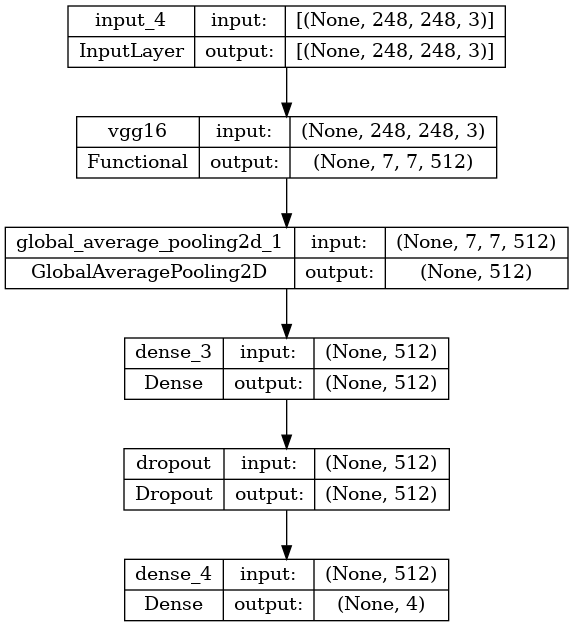

In [21]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(248, 248))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=4,
                                                         class_mode='categorical',
                                                         color_mode='rgb',
                                                         target_size=(248, 248))

Found 2768 images belonging to 4 classes.
Found 689 images belonging to 4 classes.


In [23]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [24]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2)

Epoch 1/15
87/87 - 8s - loss: 1.3435 - accuracy: 0.3468 - val_loss: 1.3064 - val_accuracy: 0.3788 - 8s/epoch - 90ms/step
Epoch 2/15
87/87 - 5s - loss: 1.2955 - accuracy: 0.3876 - val_loss: 1.2929 - val_accuracy: 0.3948 - 5s/epoch - 61ms/step
Epoch 3/15
87/87 - 5s - loss: 1.2775 - accuracy: 0.4025 - val_loss: 1.3464 - val_accuracy: 0.3512 - 5s/epoch - 62ms/step
Epoch 4/15
87/87 - 5s - loss: 1.2519 - accuracy: 0.4267 - val_loss: 1.2752 - val_accuracy: 0.3977 - 5s/epoch - 60ms/step
Epoch 5/15
87/87 - 5s - loss: 1.2222 - accuracy: 0.4400 - val_loss: 1.2768 - val_accuracy: 0.3977 - 5s/epoch - 62ms/step
Epoch 6/15
87/87 - 5s - loss: 1.2126 - accuracy: 0.4451 - val_loss: 1.3193 - val_accuracy: 0.4078 - 5s/epoch - 62ms/step
Epoch 7/15
87/87 - 5s - loss: 1.1858 - accuracy: 0.4660 - val_loss: 1.2629 - val_accuracy: 0.4078 - 5s/epoch - 61ms/step
Epoch 8/15
87/87 - 5s - loss: 1.1771 - accuracy: 0.4729 - val_loss: 1.2609 - val_accuracy: 0.3919 - 5s/epoch - 61ms/step
Epoch 9/15
87/87 - 5s - loss: 1.

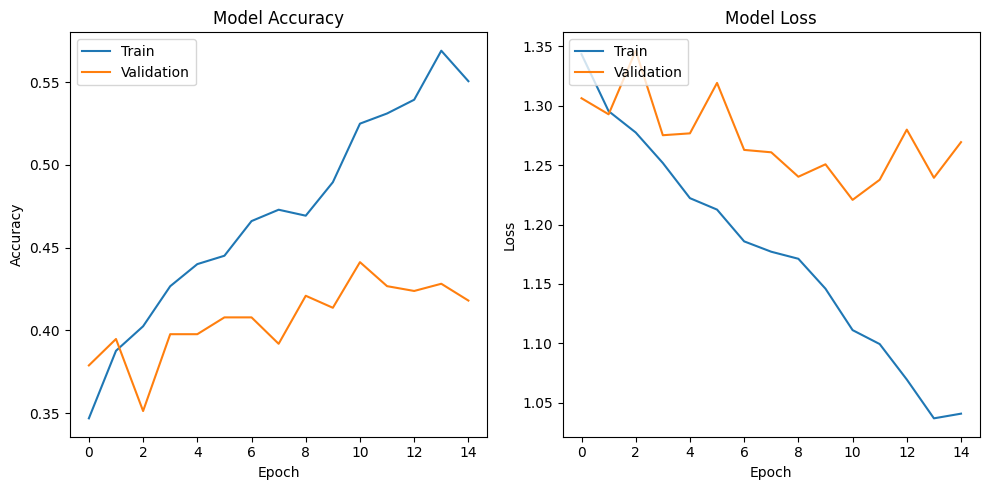

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [27]:
model.save("/home/foc-dba-38-0026-c/skin_detction/custom_model.h5")